In [1]:
import numpy as np
import pathlib
import matplotlib.pyplot as plt
from fastespy.ml import significance
from fastespy.ml import MLHyperParTuning

In [2]:
%matplotlib inline

In [6]:
suffix = 'log_pca'
#suffix = 'log_pca_class_weight'
path = pathlib.PosixPath(f"../../../ml_results_02262021_{suffix:s}/")
#path = pathlib.PosixPath(f"../../../ml_results_09202021_{suffix:s}/")
#path = pathlib.PosixPath("../../../ml_results_08172021_log_pca//")

In [7]:
classifier = "bdt"
classifier = "dt"
#classifier = "mlp"
classifier = "rf"
result = []


for p in path.glob(f"*/r{classifier:s}*.npy"):
    print(p)
    r = np.load(p, allow_pickle=True).flat[0]
    result.append(r)

In [8]:
result[0]['dark_current']

IndexError: list index out of range

In [ ]:
for r in result:
    print(r['results']['best_params']['Significance'])

In [ ]:
for r in result:
    MLHyperParTuning.plot_parameter_profiles(r['results'],["Significance"], classifier, path=None)

In [ ]:
fig = plt.figure(figsize=(6,10))

ax_sig = plt.subplot(311)
ax_bkg = plt.subplot(312)
ax_eff = plt.subplot(313)

thr = result[0]['results']['thresholds']

for t in ['train', 'test']:
    
    for i, ax in enumerate([ax_sig, ax_bkg, ax_eff]):
        y = np.array([r['results']['thr_sig_bkg_eff_{0:s}'.format(t)]["Significance"][i] for r in result])    
        ax.plot(thr, y.mean(axis=0), label=t if not i else "")
#        ax.fill_between(thr, y.min(axis=0), y2=y.max(axis=0), alpha=0.5)
        ax.fill_between(thr, y.mean(axis=0) - np.sqrt(y.var(axis=0)),
                        y2=y.mean(axis=0) + np.sqrt(y.var(axis=0)), alpha=0.5)
    
        if t == 'test':
            if i == 1:
                ax.set_yscale("log")
                ax.set_ylabel("Background rate (Hz)")
            ax.grid(True)
        
            if not i == 2:
                ax.tick_params(labelbottom=False, direction="in")
                if not i:
                    ax.set_ylabel(r"Signficance ($\sigma$)")
                    ax.legend(loc=2)
            else:
                ax.set_xlabel("Threshold")
                ax.set_ylabel("Efficiency")
            
fig.subplots_adjust(hspace=0.)
fig.suptitle(classifier, y=0.9)

plt.savefig(f"./sig_bkg_eff_{suffix:s}_{classifier:s}.png", dpi=120)

In [ ]:
result[0]['results'].keys()

In [ ]:
for r in result:
    plt.figure()
    for score, val in r['results']['learning_curve'].items():
    
        if not score == 'Significance':
            continue
    
        train_sizes, train_scores, valid_scores = val
    
        plt.plot(train_sizes, train_scores.mean(axis=1),
                 marker='o',
                 label=score + " Train",
                 ls='--',
                 color='g' if score == 'AUC' else 'k'
                )
        plt.fill_between(train_sizes,
                         train_scores.mean(axis=1) - np.sqrt(train_scores.var()),
                         y2=train_scores.mean(axis=1) + np.sqrt(train_scores.var()),
                         alpha=0.3,
                         color='g' if score == 'AUC' else 'k',
                         zorder=-1
                        )
    
        plt.plot(train_sizes, valid_scores.mean(axis=1),
                 marker='o',
                 label=score + " valid", ls='-',
                 color= 'g' if score == 'AUC' else 'k',
                )
        plt.fill_between(train_sizes,
                         valid_scores.mean(axis=1) - np.sqrt(valid_scores.var()),
                         y2=valid_scores.mean(axis=1) + np.sqrt(valid_scores.var()),
                         alpha=0.3,
                         color='g' if score == 'AUC' else 'k',
                         zorder=-1
                        )

    plt.legend(title=classifier)
    plt.grid()
    plt.xlabel("Sample Size")
    plt.ylabel("Score")


For one scorer, plot the dark current rate for each iteration as well as the signficance

In [ ]:
scorer = "Significance"

fig = plt.figure(dpi=150, figsize=(6,5))
ax = fig.add_subplot(211)
ax2 = fig.add_subplot(212)


for i, r in enumerate(result):
    ax.errorbar(i+1, r['dark_current'][scorer][1] * 1e6, 
                yerr=np.array([[r['dark_current'][scorer][1] - r['dark_current'][scorer][0]],
                      [r['dark_current'][scorer][2] - r['dark_current'][scorer][1]]]) * 1e6,
                marker='o', color="C0")
    
    print(i, r['dark_current'][scorer][1])
    
    sig = significance(n_b=r['dark_current'][scorer],
                   obs_time=r['t_obs'],
                   e_a=r['results']['tp_efficiency_test'][scorer]
                   )
    
    ax2.errorbar(i+1, sig[1],
            yerr=np.array([[sig[1] - sig[0]],
                           [sig[2] - sig[1]]]),
             marker='o', color="C3")
    
    
ax.grid()
ax2.grid()

plt.suptitle(classifier)
ax.set_xticks(np.arange(1,len(result)+1))
ax2.set_xticks(np.arange(1,len(result)+1))
ax.tick_params(labelbottom=False)

ax.set_ylabel("Dark Current (10$^{-6}$ Hz)")
ax2.set_ylabel(r"Significance ($\sigma$)")
plt.xlabel("K Fold")

Text(0.5, 0, 'Scorer')

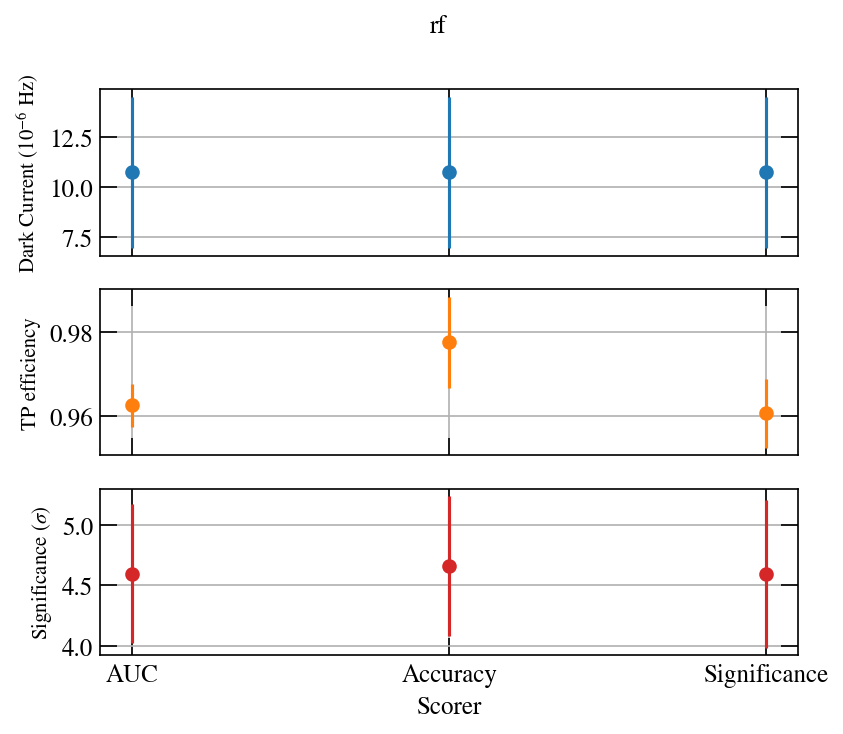

In [15]:
fig = plt.figure(dpi=150, figsize=(6,5))
ax = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

for i, scorer in enumerate(r['scoring']):

    dc = []
    sig = []
    tpr = []
    
    for j, r in enumerate(result):
        
        dc.append(r['dark_current'][scorer][1] * 1e6)
        tpr.append(r['results']['tp_efficiency_test'][scorer])
        sig.append(significance(n_b=dc[-1] / 1e6,
                   obs_time=r['t_obs'],
                   e_a=tpr[-1]
                   ))
    ax.errorbar(i + 1, np.mean(dc), yerr=np.sqrt(np.var(dc)), marker='o', color='C0')
    ax2.errorbar(i + 1, np.mean(tpr), yerr=np.sqrt(np.var(tpr)), marker='o', color='C1')
    ax3.errorbar(i + 1, np.mean(sig), yerr=np.sqrt(np.var(sig)), marker='o', color='C3')
    
    
ax.grid()
ax2.grid()
ax3.grid()

plt.suptitle(classifier)

ax.tick_params(labelbottom=False)
ax2.tick_params(labelbottom=False)

ax.set_ylabel("Dark Current (10$^{-6}$ Hz)", fontsize='medium')
ax2.set_ylabel(r"TP efficiency", fontsize='medium')
ax3.set_ylabel(r"Significance ($\sigma$)", fontsize='medium')


ax.set_xticks(np.arange(1,len(r['scoring'])+1))
ax2.set_xticks(np.arange(1,len(r['scoring'])+1))
plt.xticks(np.arange(1,len(r['scoring'])+1), r['scoring'])
plt.xlabel("Scorer")

### Loop over different classifier

In [1]:
classifier = ["rf", "bdt", "mlp"]
#classifier = ["dt", "rf"]

result = {}

for i, c in enumerate(classifier):

    result[c] = []
    
    for p in path.glob(f"*/r{c:s}*.npy"):
        print(p)
        r = np.load(p, allow_pickle=True).flat[0]
        result[c].append(r)

NameError: name 'path' is not defined

Text(0.5, 0, 'Classifier')

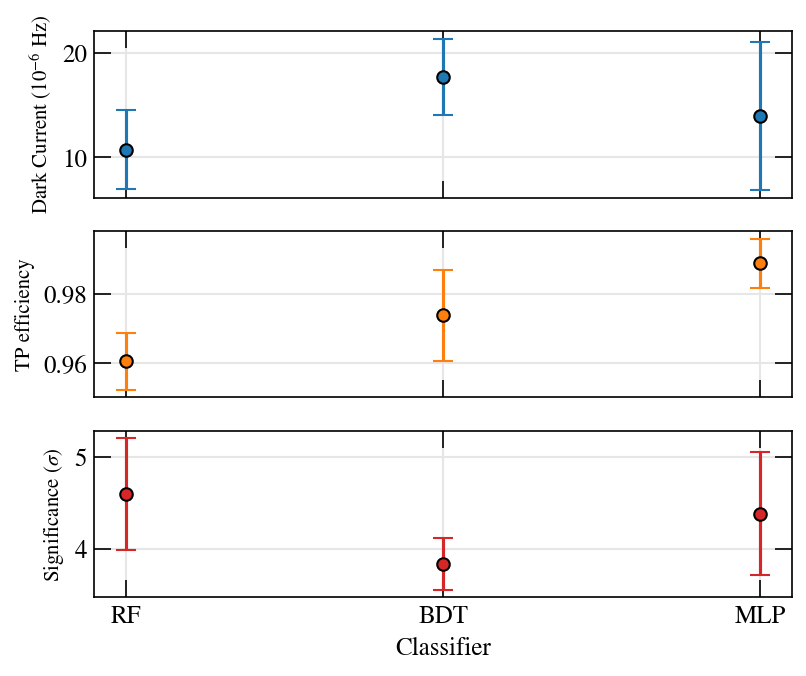

In [17]:

fig = plt.figure(dpi=150, figsize=(6,5))
ax = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

scorer = "Significance"

cs = 5.

for i, c in enumerate(classifier):

    dc = []
    sig = []
    tpr = []
    
    for j, r in enumerate(result[c]):
        
        dc.append(r['dark_current'][scorer][1] * 1e6)
        tpr.append(r['results']['tp_efficiency_test'][scorer])
        sig.append(significance(n_b=dc[-1] / 1e6,
                   obs_time=r['t_obs'],
                   e_a=tpr[-1]
                   ))
    ax.errorbar(i + 1, np.mean(dc), yerr=np.sqrt(np.var(dc)), marker='o', color='C0', capsize=cs, mec='k')
    ax2.errorbar(i + 1, np.mean(tpr), yerr=np.sqrt(np.var(tpr)), marker='o', color='C1', capsize=cs, mec='k')
    ax3.errorbar(i + 1, np.mean(sig), yerr=np.sqrt(np.var(sig)), marker='o', color='C3', capsize=cs, mec='k')
    
    
ax.grid(lw=1, color="0.9")
ax2.grid(lw=1, color="0.9")
ax3.grid(lw=1, color="0.9")

ax.tick_params(labelbottom=False)
ax2.tick_params(labelbottom=False)

ax.set_ylabel("Dark Current (10$^{-6}$ Hz)", fontsize='medium')
ax2.set_ylabel(r"TP efficiency", fontsize='medium')
ax3.set_ylabel(r"Significance ($\sigma$)", fontsize='medium')


ax.set_xticks(np.arange(1,len(classifier)+1))
ax2.set_xticks(np.arange(1,len(classifier)+1))
plt.xticks(np.arange(1,len(classifier)+1), [c.upper() for c in classifier])
plt.xlabel("Classifier")